In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 創建範例資料
raw = pd.read_csv('project\DA\gb.csv')

# z-score 標準化
raw["z_score"] = (raw["mean_pnl"] - raw["mean_pnl"].mean()) / raw["mean_pnl"].std()
raw.query("z_score > 3 | z_score < -3")

outlier_removed = raw.drop(raw.query("z_score > 3 | z_score < -3").index)

X = outlier_removed[["active_weeks","mean_pnl"]].to_numpy()

##### K-means 演算法

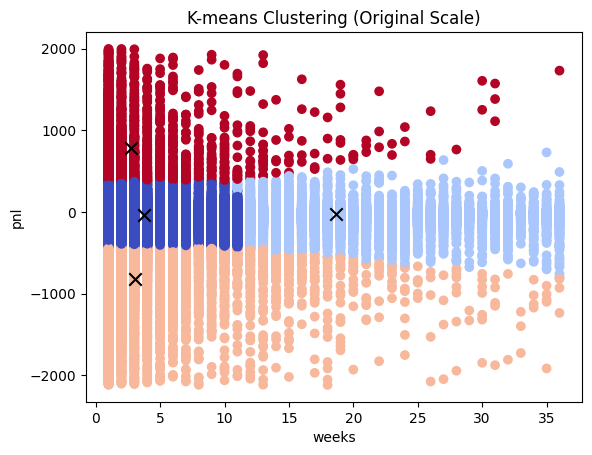

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator  # 確保你已安裝 kneed 庫： pip install kneed

# 計算不同 k 值的 SSE
sse = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# 使用 Kneedle Algorithm 自動識別肘部位置
kl = KneeLocator(K, sse, curve='convex', direction='decreasing')
optimal_k = kl.elbow

# 初始化標準化器和 KMeans 模型
scaler = StandardScaler()
kmeans = KMeans(n_clusters = optimal_k, random_state=0)

# 標準化數據並訓練模型
X_scaled = scaler.fit_transform(X)
kmeans.fit(X_scaled)

# 獲取分群的結果
labels = kmeans.labels_

# 獲取每個群集的中心點（在標準化數據空間）
centroids_scaled = kmeans.cluster_centers_

# 將群集中心點還原到原始數據空間
centroids_original = scaler.inverse_transform(centroids_scaled)

# 還原標準化的數據
X_original = scaler.inverse_transform(X_scaled)

# 繪製資料點，使用分群標籤進行顏色區分（原始值為軸）
plt.scatter(X_original[:, 0], X_original[:, 1], c=labels, cmap='coolwarm')

# 繪製群集中心點（原始值為軸）
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], marker='x', s=80, color='black')
plt.title('K-means Clustering (Original Scale)')
plt.xlabel('weeks')
plt.ylabel('pnl')
plt.show()

##### 階層式聚類

In [ ]:
import scipy.cluster.hierarchy as sch

# 使用階層式聚類
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

ps. 電腦跑不動

階層聚類的樹狀圖（dendrogram）顯示了數據點之間的距離和聚合過程。樹的高度代表了數據點之間的距離，可以幫助決定適合的聚類數目。

##### 主成分分析

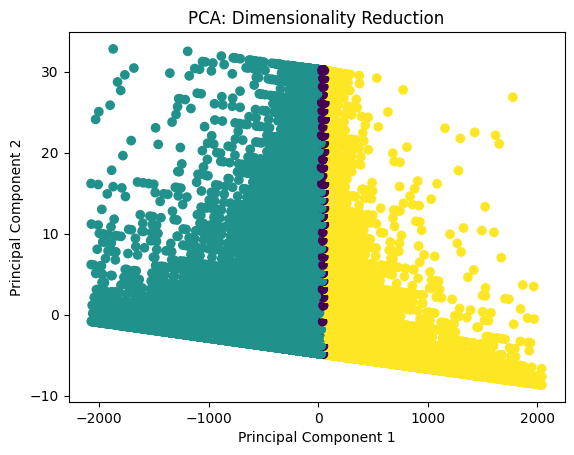

: 

In [53]:
from sklearn.decomposition import PCA

# 將數據降到2維進行PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis')
plt.title('PCA: Dimensionality Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

圖中顯示數據降維後的兩個主成分，這能幫助理解數據的主要變異源。PCA有助於減少特徵維度，提高計算效率，並發現主要特徵。

##### 孤立森林算法 (Isolation Forest)

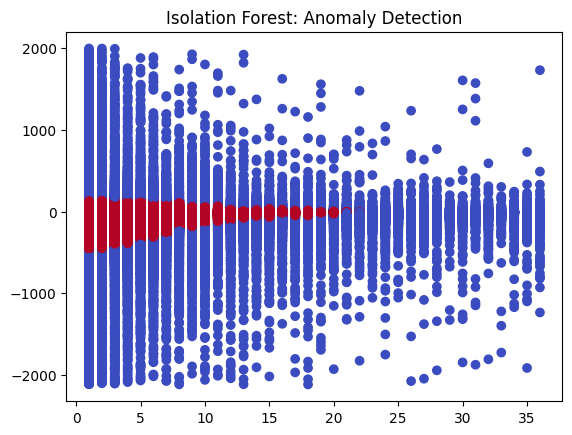

In [28]:
from sklearn.ensemble import IsolationForest

# 使用孤立森林進行異常檢測
iso_forest = IsolationForest(contamination=0.1)
y_pred = iso_forest.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')
plt.title('Isolation Forest: Anomaly Detection')
plt.show()

圖中顏色不同的點代表正常數據點和異常數據點。該方法有助於識別和剔除數據中的異常行為，通常用於檢測作弊或異常行為。

##### 自組織映射 (SOM)

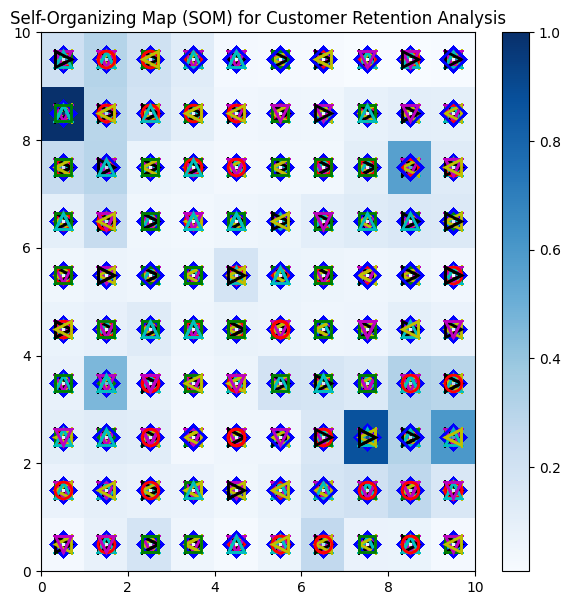

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom

# 初始化SOM的大小和參數
som = MiniSom(x=10, y=10, input_len=2, sigma=0.3, learning_rate=0.5, random_seed=42) # 設置隨機種子以保證結果可重複

# 初始化權重並訓練SOM
som.random_weights_init(X)
som.train_random(data=X, num_iteration=100)

# 可視化結果
plt.figure(figsize=(7, 7))
plt.pcolor(som.distance_map().T, cmap='Blues')  # 繪製距離地圖
plt.colorbar()

# 標註數據點
markers = ['o', 's', 'D', '^', 'v', '<', '>']
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for i, x in enumerate(X):
    w = som.winner(x)  # 找到每個數據點的勝出節點
    plt.plot(w[0] + 0.5, w[1] + 0.5, markers[i % len(markers)], markerfacecolor='None',
             markeredgecolor=colors[i % len(colors)], markersize=12, markeredgewidth=2)

plt.title('Self-Organizing Map (SOM) for Customer Retention Analysis')
plt.show()

SOM的距離圖顯示了數據點之間的相似度，顏色越深表示點之間的距離越大。該方法可以用來直觀理解數據點之間的內部結構和關聯性

##### 密度聚類算法 (DBSCAN)

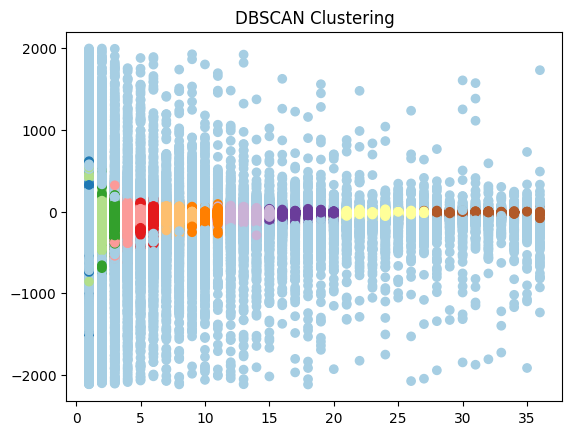

In [47]:
from sklearn.cluster import DBSCAN

# 使用DBSCAN進行聚類
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_dbscan, cmap='Paired')
plt.title('DBSCAN Clustering')
plt.show()  

圖中的顏色代表不同的集群，-1表示噪聲點。DBSCAN擅長於識別任意形狀的集群，同時能有效處理噪聲數據。

##### 高斯混合模型 (GMM)

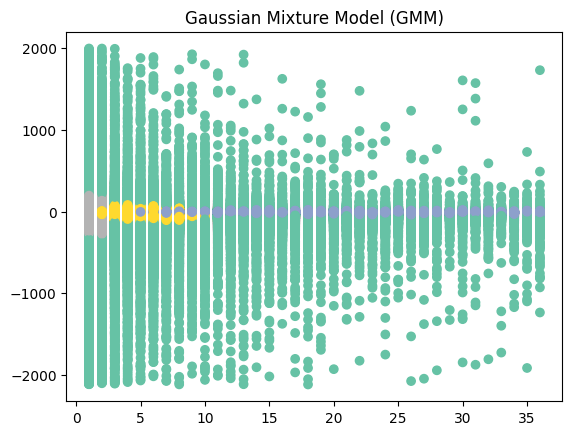

In [48]:
from sklearn.mixture import GaussianMixture

# 使用GMM進行聚類
gmm = GaussianMixture(n_components=4)
gmm.fit(X)
y_gmm = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='Set2')
plt.title('Gaussian Mixture Model (GMM)')
plt.show()

圖中的顏色表示不同的高斯分佈群體。這些群體依據高斯分佈的概率密度進行劃分，可以更靈活地捕捉數據的多樣性，特別適合處理具有不同分佈的數據。